In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set style
sns.set_theme(style="whitegrid")

# 1. Load Data
file_path = os.path.join("..", "Data", "processed", "h3_podcast_processed.csv")
df = pd.read_csv(file_path)

# 2. FORCE RE-CALCULATION (The Fix)
# We calculate these columns right now to ensure they exist
df['like_ratio'] = df['like_count'] / df['view_count']
df['engagement_rate'] = (df['like_count'] + df['comment_count']) / df['view_count']

print(f"Data Loaded: {df.shape[0]} episodes.")
print("Columns available:", df.columns.tolist()) 
# You should now see 'like_ratio' in the list printed above

Data Loaded: 199 episodes.
Columns available: ['video_id', 'title', 'published_at', 'view_count', 'like_count', 'comment_count', 'description', 'sponsors', 'category', 'like_ratio', 'engagement_rate']


C:\Users\17025\AppData\Local\Temp\ipykernel_23472\1678055257.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='category', y='like_ratio', order=tier_order, palette="viridis")


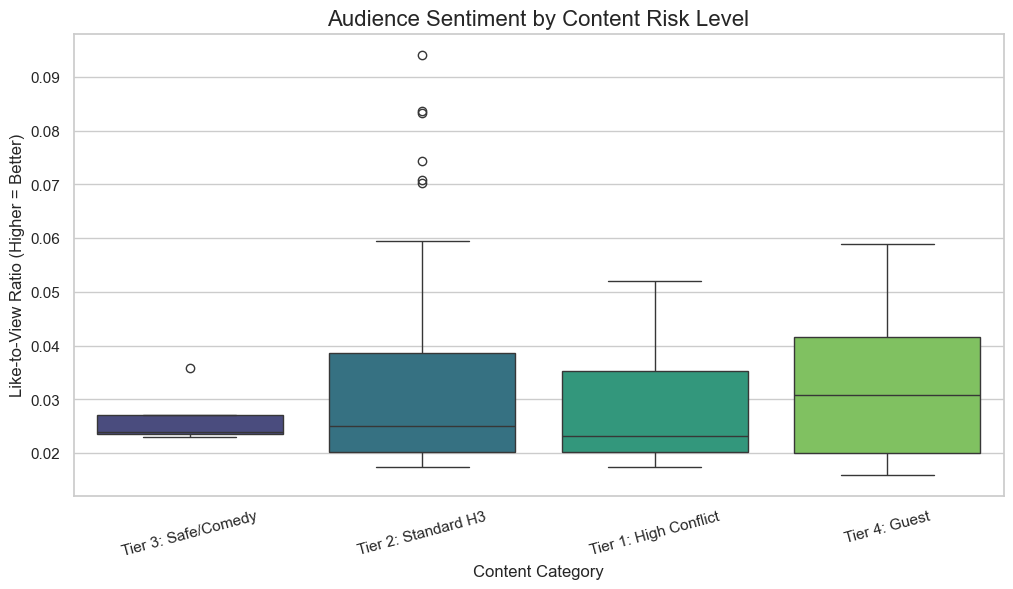

Average Like Ratio per Category:
category
Tier 4: Guest            0.032734
Tier 2: Standard H3      0.031208
Tier 1: High Conflict    0.027651
Tier 3: Safe/Comedy      0.026695
Name: like_ratio, dtype: float64


In [5]:
# Define the order of tiers for the chart
tier_order = ["Tier 3: Safe/Comedy", "Tier 2: Standard H3", "Tier 1: High Conflict", "Tier 4: Guest"]

# Create the visualization
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='category', y='like_ratio', order=tier_order, palette="viridis")

plt.title('Audience Sentiment by Content Risk Level', fontsize=16)
plt.ylabel('Like-to-View Ratio (Higher = Better)', fontsize=12)
plt.xlabel('Content Category', fontsize=12)
plt.xticks(rotation=15)

plt.show()

# Calculate the actual average numbers to confirm the visual
print("Average Like Ratio per Category:")
print(df.groupby('category')['like_ratio'].mean().sort_values(ascending=False))

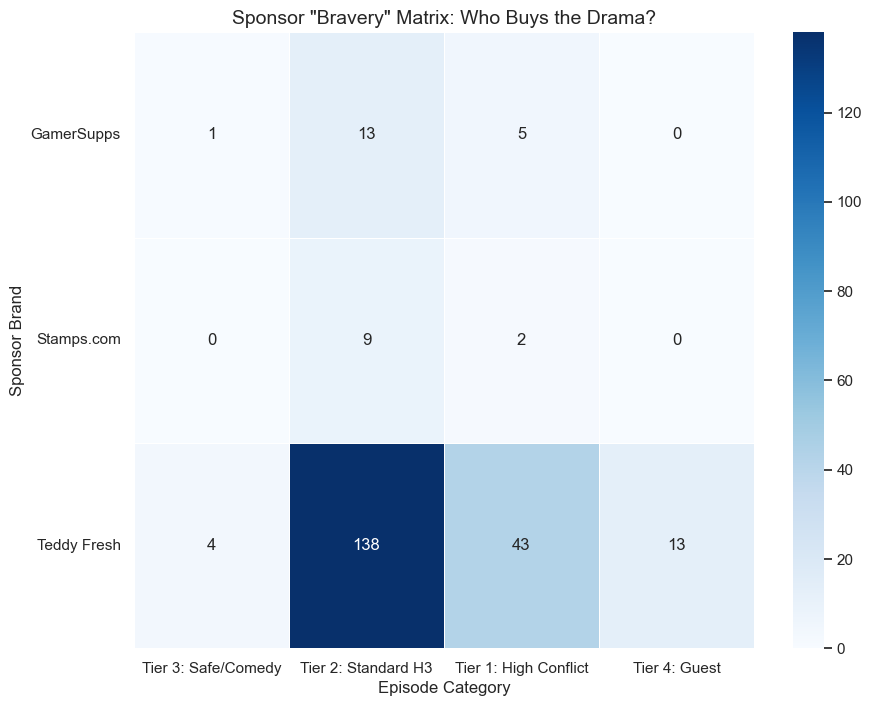

In [8]:
# --- VISUALIZATION 2: SPONSOR STRATEGY HEATMAP (POLISHED) ---

# 1. Clean the Sponsor String formatting artifact
# This removes the brackets [' '] and quotes ' that might have stuck to the text
df['sponsors_clean'] = df['sponsors'].astype(str).str.replace(r"[\[\]']", "", regex=True)

# 2. Explode the cleaned sponsors
df_sponsors = df.assign(sponsors_split=df['sponsors_clean'].str.split(', ')).explode('sponsors_split')

# 3. Filter out "None" or empty strings
df_sponsors = df_sponsors[df_sponsors['sponsors_split'] != "None"]
df_sponsors = df_sponsors[df_sponsors['sponsors_split'] != ""]

# 4. Get Top 10 filtered sponsors
if not df_sponsors.empty:
    top_sponsors = df_sponsors['sponsors_split'].value_counts().head(10).index
    df_top = df_sponsors[df_sponsors['sponsors_split'].isin(top_sponsors)]

    # 5. Create Matrix
    sponsor_matrix = pd.crosstab(df_top['sponsors_split'], df_top['category'])

    # Reorder columns
    column_order = ["Tier 3: Safe/Comedy", "Tier 2: Standard H3", "Tier 1: High Conflict", "Tier 4: Guest"]
    existing_cols = [c for c in column_order if c in sponsor_matrix.columns]
    sponsor_matrix = sponsor_matrix[existing_cols]

    # 6. Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(sponsor_matrix, annot=True, fmt="d", cmap="Blues", linewidths=.5)

    plt.title('Sponsor "Bravery" Matrix: Who Buys the Drama?', fontsize=14)
    plt.ylabel('Sponsor Brand', fontsize=12)
    plt.xlabel('Episode Category', fontsize=12)
    plt.yticks(rotation=0)

    plt.show()
else:
    print("⚠️ No sponsors found.")

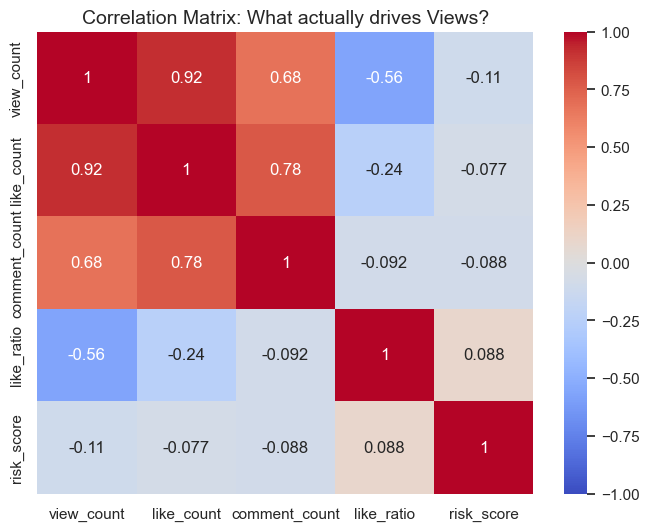

Interpretation Guide:
- If 'risk_score' has a NEGATIVE correlation with Views, it means Higher Risk (Lower Score) = Higher Views.


In [9]:
# --- VISUALIZATION 3: CORRELATION MATRIX ---

# 1. Convert Categorical Tiers to Numbers so the machine can read them
# High Drama (1) -> Standard (2) -> Safe (3) -> Guest (4)
# This lets us test: "Does lower risk (higher number) equal higher views?"
tier_mapping = {
    "Tier 1: High Conflict": 1, 
    "Tier 2: Standard H3": 2, 
    "Tier 3: Safe/Comedy": 3, 
    "Tier 4: Guest": 4
}
df['risk_score'] = df['category'].map(tier_mapping)

# 2. Select numerical columns for correlation
cols_to_test = ['view_count', 'like_count', 'comment_count', 'like_ratio', 'risk_score']
corr_matrix = df[cols_to_test].corr()

# 3. Plot the Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation Matrix: What actually drives Views?', fontsize=14)
plt.show()

print("Interpretation Guide:")
print("- If 'risk_score' has a NEGATIVE correlation with Views, it means Higher Risk (Lower Score) = Higher Views.")